Instalando bibliotecas necessárias para análise do grafo.

In [ ]:
!pip install osmnx

Agora, gerando o grafo de Blumenau, cidade escolhida pela equipe para realizar o trabalho.

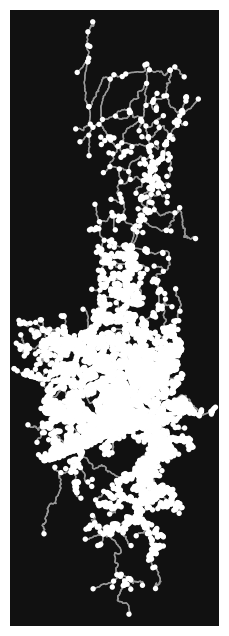

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [2]:
import networkx as nx
import osmnx as ox

PLACE = 'Blumenau, Brazil'

G: nx.MultiDiGraph = ox.graph_from_place(
    PLACE,
    network_type='drive'
)

ox.plot_graph(G)

Próximo passo é importar os dados das planilhas para o grafo. Para este processo, foram coletadas longitude (x) e latitude (y) de cada ponto de interesse e no grafo vamos atribuir um "label" e "nome" para o vértice mais próximo ao ponto de interesse desejado. Ou seja, para o Hospital Santa Isabel, por exemplo, o vértice mais próximo da coordenada que informamos no dataframe vai ser utilizado.

Dados:

- hospitais públicos e privados
- escolas públicas (municipais) e privadas
- creches
- pontos de saúde (AGs, ESFs e Laboratórios)
- centros de atendimento social e psicológico (CRAS e CAPS)

In [3]:
import pandas as pd
import networkx as nx

"""
  Labels with `label` the points of interest from a `dataframe` in a graph `G`.
"""
def label_points_of_interest(G: nx.MultiDiGraph, dataframe: pd.DataFrame, label: str):
  for idx, row in df.iterrows():
    x = row['x']
    y = row['y']
    name = row['name']

    nearest_node_from_interest_point = ox.distance.nearest_nodes(G, X=x, Y=y)

    G.nodes[nearest_node_from_interest_point]['name'] = name
    G.nodes[nearest_node_from_interest_point]['label'] = label

dataframes = {
    'hospital': 'https://raw.githubusercontent.com/lemuel-manske/city-block/main/data/hospitals.csv',
}

for label, url in dataframes.items():
  df = pd.read_csv(url)
  label_points_of_interest(G, df, label)

Para facilitar a análise, vamos separar as vias em bairros:

<Axes: >

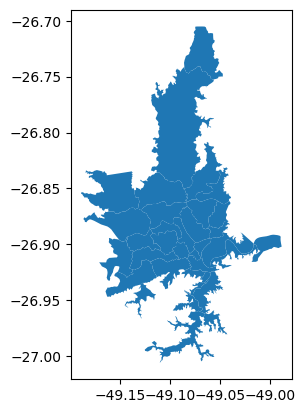

In [21]:
import osmnx as ox

PLACE = 'Blumenau, Brazil'

# https://www.blumenau.sc.gov.br/secretarias/secretaria-de-desenvolvimento-urbano/pagina/historia-sobre-municipio/divisa-administrativa-bairros
NOT_DESIRED_HEIGHBORHOODS = [
    'Belchior Baixo',
    'Belchior Alto',
    'Belchior Central',
    'Gaspar Alto',
    'Gaspar Grande',
    'Figueira',
    'Ribeirão Fresco',
    'Encano do Norte',
    'Encano Baixo',
    'Encano Central',
    'Encano Alto',
    'Sternthal',
    'Gruenerwinkel',
    'Planície Alta',
    'Treze de Maio',
    'Ribeirão Humberto',
    'Rio Bonito',
    'Terceiro Braço',
    'Sete de Janeiro',
]

neighborhood_tags = { 'admin_level': '10' } # https://wiki.openstreetmap.org/wiki/Key:admin_level

neighborhoods = ox.features.features_from_place(PLACE, neighborhood_tags) \
  .query(f'name not in {NOT_DESIRED_HEIGHBORHOODS}')

neighborhoods.plot()